# Twitter Education Data - Preprocessing and Analysis

## Data Preparation

### Load Libraries

In [1]:
import GetOldTweets3 as got
import pandas as pd
import warnings
import re
import numpy as np
import tweepy as tw
from tweepy.streaming import StreamListener
import sys
import matplotlib.pyplot as plt
import json
from datetime import datetime
import shutil

# NTLK functions
import nltk
from nltk.corpus import stopwords
from nltk import tokenize as tok
from nltk.stem.snowball import SnowballStemmer # load nltk's SnowballStemmer as variabled 'stemmer'
import lda # topic modeling -NMF & LDA
import string
from nltk.tag import StanfordNERTagger

warnings.simplefilter("ignore", DeprecationWarning)
# Load the LDA model from sk-learn
from sklearn.decomposition import LatentDirichletAllocation as LDA
# Tf-Idf and Clustering packages
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer

### Combine different txt files containing streamed Tweets into a single text file

In [2]:
filenames = ['educationTweets1.txt', 'educationTweets2.txt', 'educationTweets3.txt', 'educationTweets4.txt', 'educationTweets5.txt', 'educationTweets6.txt','educationTweets7.txt', 'educationTweets8.txt', 'educationTweets5.txt', 'educationTweets6.txt','educationTweets7.txt', 'educationTweets8.txt', 'educationTweets9.txt']

with open('rawEducationTweets.txt','wb') as wfd:
    for f in filenames:
        with open(f,'rb') as fd:
            shutil.copyfileobj(fd, wfd)

### Read in file with Tweets

In [3]:
tweets_data_path = '/Users/jordanvargas/Desktop/UWGreenBay/DS785-Capstone/WebScraping/Twitter/rawEducationTweets.txt'

tweets_data = []
tweets_file = open(tweets_data_path, "r")
for line in tweets_file:
    try:
        tweet = json.loads(line)
        tweets_data.append(tweet)
    except:
        continue

In [4]:
len(tweets_data)

26478

### Define Functions to Flatten Twitter Data and Select Desired Text

In [5]:
def flatten_tweets(tweets):
    """ Flattens out tweet dictionaries so relevant JSON is 
        in a top-level dictionary. """
    
    tweets_list = []
    
    # Iterate through each tweet
    for tweet_obj in tweets:
    
        ''' User info'''
        # Store the user screen name in 'user-screen_name'
        tweet_obj['user-screen_name'] = tweet_obj['user']['screen_name']
        
        # Store the user location
        tweet_obj['user-location'] = tweet_obj['user']['location']
        
    
        ''' Text info'''
                                               
        # Check if this is a 140+ character tweet
        if 'extended_tweet' in tweet_obj:
            # Store the extended tweet text in 'extended_tweet-full_text'
            tweet_obj['extended_tweet-full_text'] = tweet_obj['extended_tweet']['full_text']
    
        if 'retweeted_status' in tweet_obj:
            # Store the retweet user screen name in 
            # 'retweeted_status-user-screen_name'
            tweet_obj['retweeted_status-user-screen_name'] = tweet_obj['retweeted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['retweeted_status-text'] = tweet_obj['retweeted_status']['text']
            
            #Store the retweet count in 'retweeted_status-count'
            tweet_obj['retweeted_status-count'] = tweet_obj['retweeted_status']['retweet_count']
    
            if 'extended_tweet' in tweet_obj['retweeted_status']:
                # Store the extended retweet text in 
                #'retweeted_status-extended_tweet-full_text'
                tweet_obj['retweeted_status-extended_tweet-full_text'] = tweet_obj['retweeted_status']['extended_tweet']['full_text']
                
        if 'quoted_status' in tweet_obj:
            # Store the retweet user screen name in 
            #'retweeted_status-user-screen_name'
            tweet_obj['quoted_status-user-screen_name'] = tweet_obj['quoted_status']['user']['screen_name']

            # Store the retweet text in 'retweeted_status-text'
            tweet_obj['quoted_status-text'] = tweet_obj['quoted_status']['text']
    
            if 'extended_tweet' in tweet_obj['quoted_status']:
                # Store the extended retweet text in 
                #'retweeted_status-extended_tweet-full_text'
                tweet_obj['quoted_status-extended_tweet-full_text'] = tweet_obj['quoted_status']['extended_tweet']['full_text']
        
        if 'entities' in tweet_obj:
            tweet_obj['entities-hashtags'] = tweet_obj['entities']['hashtags']
        tweets_list.append(tweet_obj)
        
    return tweets_list

In [6]:
def select_text(tweets):
    ''' Assigns the main text to only one column depending
        on whether the tweet is a RT/quote or not'''
    
    tweets_list = []
    
    # Iterate through each tweet
    for tweet_obj in tweets:
        
        if 'retweeted_status-extended_tweet-full_text' in tweet_obj:
            tweet_obj['text'] = tweet_obj['retweeted_status-extended_tweet-full_text']
        
        elif 'retweeted_status-text' in tweet_obj:
            tweet_obj['text'] = tweet_obj['retweeted_status-text']
            
        elif 'extended_tweet-full_text' in tweet_obj:
            tweet_obj['text'] = tweet_obj['extended_tweet-full_text']
        else:
            tweet_obj['text'] = tweet_obj['text']
                
        tweets_list.append(tweet_obj)
        
    return tweets_list

### Build a Dataframe

In [7]:
# flatten tweets
tweets = flatten_tweets(tweets_data)

In [8]:
# select text
tweets = select_text(tweets)

In [9]:
# columns to explore
columns = ['user-screen_name','text','user-location','lang', 'entities-hashtags', 'retweeted_status-count', 'created_at']

In [10]:
# Create a DataFrame from `tweets`
df_tweets = pd.DataFrame(tweets, columns=columns)

In [11]:
df_tweets.head(25)

,user-screen_name,text,user-location,lang,entities-hashtags,retweeted_status-count,created_at
0,GregKiesman,The latest The Digital Teacher! https://t.co/4...,"Winnipeg, Manitoba, Canada",en,"[{'text': 'education', 'indices': [56, 66]}, {...",NaN,Tue Jul 06 13:09:59 +0000 2021
1,BenicioMoveis,#educators #education #edtech #teachers #princ...,None,und,"[{'text': 'educators', 'indices': [0, 10]}, {'...",NaN,Tue Jul 06 13:10:33 +0000 2021
2,karlDcollins,Still looking for #freelance #science writers....,Germany since 2012 (prev. UK),en,"[{'text': 'freelance', 'indices': [18, 28]}, {...",NaN,Tue Jul 06 13:11:28 +0000 2021
3,maidanulada,Would you like to watch a shortish video on ho...,"Bangkok, Thailand",en,[],75.0,Tue Jul 06 13:11:30 +0000 2021
4,Ballewedtech,"Please join me in #celebrating @janetmelling, ...","Bloomington, MN",en,"[{'text': 'celebrating', 'indices': [38, 50]},...",1.0,Tue Jul 06 13:11:31 +0000 2021
5,patriclougheed,The latest Blended Learning Daily! https://t.c...,Vancouver Island,en,"[{'text': 'tesol', 'indices': [110, 116]}, {'t...",NaN,Tue Jul 06 13:11:59 +0000 2021
6,maidanulada,"Have you had both doses of the vaccine? Then, ...","Bangkok, Thailand",en,[],31.0,Tue Jul 06 13:12:29 +0000 2021
7,education_24x7,Simple things you can do as a teacher to ensur...,Delhi,en,"[{'text': 'edchat', 'indices': [127, 134]}]",1.0,Tue Jul 06 13:12:41 +0000 2021
8,GPHarvard,"In our webinar ""Teaching Good Work in the Clas...",Harvard University,en,[],NaN,Tue Jul 06 13:13:03 +0000 2021
9,jenallen_edtech,There are a lot of buzzwords floating around i...,None,en,[],1.0,Tue Jul 06 13:13:14 +0000 2021


## Twitter Data Cleaning and Exploration

### Working with hashtags and retweet counts

In [12]:
# Clean hashtags column
hashtag_storage = []
for record in df_tweets['entities-hashtags']:
    hashtag_storage.append([ sub['text'] for sub in record])
    
# Create new column with hashtags   
df_tweets['hashtags'] = hashtag_storage

# Replace empty lists with None for hashtag column
df_tweets['hashtags'] = df_tweets['hashtags'].apply(lambda y: np.nan if len(y)==0 else y)
df_tweets['hashtags'] = df_tweets['hashtags'].replace({np.nan: None})

#Remove entities-hashtags
del df_tweets['entities-hashtags']

In [13]:
# Replace Nans with 0s in retweeted_status-count
df_tweets['retweeted_status-count'] = df_tweets['retweeted_status-count'].fillna(0)

# Rename retweet count column for clarity
df_tweets.rename(columns={'retweeted_status-count':'retweet_count'},inplace=True)

In [14]:
#Remove any tweets that have no text data
df_tweets = df_tweets[df_tweets['text'].notna()]

In [15]:
df_tweets.head(5)

,user-screen_name,text,user-location,lang,retweet_count,created_at,hashtags
0,GregKiesman,The latest The Digital Teacher! https://t.co/4...,"Winnipeg, Manitoba, Canada",en,0.0,Tue Jul 06 13:09:59 +0000 2021,"[education, k12]"
1,BenicioMoveis,#educators #education #edtech #teachers #princ...,None,und,0.0,Tue Jul 06 13:10:33 +0000 2021,"[educators, education, edtech, teachers, princ..."
2,karlDcollins,Still looking for #freelance #science writers....,Germany since 2012 (prev. UK),en,0.0,Tue Jul 06 13:11:28 +0000 2021,"[freelance, science]"
3,maidanulada,Would you like to watch a shortish video on ho...,"Bangkok, Thailand",en,75.0,Tue Jul 06 13:11:30 +0000 2021,None
4,Ballewedtech,"Please join me in #celebrating @janetmelling, ...","Bloomington, MN",en,1.0,Tue Jul 06 13:11:31 +0000 2021,"[celebrating, GCEL2, GoogleEDU]"


### Language Count Visualization

<AxesSubplot:title={'center':'Top 5 languages'}, xlabel='Languages', ylabel='Number of tweets'>

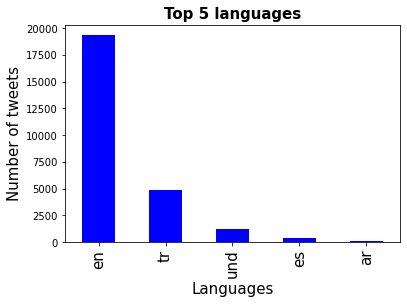

In [16]:
#Language Count Graphic
tweets_by_lang = df_tweets['lang'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Languages', fontsize=15)
ax.set_ylabel('Number of tweets' , fontsize=15)
ax.set_title('Top 5 languages', fontsize=15, fontweight='bold')
tweets_by_lang[:5].plot(ax=ax, kind='bar', color='blue')

#tweets_by_lang[0:5]
#english     19365
#turkish      4823
#undetermined  1204
#spanish       360
#arabic       130

### Further Cleaning of Dataset

In [17]:
#export CSV for further review
df_tweets.to_csv('df_tweets.csv', index=True)

In [18]:
'''We notice that several of the Tweets in languages other than English were possibly
included via chance of aligning with our search terms. We decide to focus on just English-based Tweets'''
df_tweets_en = df_tweets[df_tweets['lang'] == 'en']
len(df_tweets_en)

19365

### Tagging our Tweets (STEAM/STEM, ELD, SEL, ESSER, k12) - Manual Approach

In [21]:
# Tagging Functions
def word_in_text(word, text):
    word = word.lower()
    text = text.lower()
    match = re.search(word, text)
    if match:
        return True
    else:
        return False

def words_in_text(word1, word2, text):
    word1 = word1.lower()
    word2 = word2.lower()
    text = text.lower()
    match1 = re.search(word1, text)
    match2 = re.search(word2, text)
    if match1:
        return True
    elif match2:
        return True
    else:
        return False

In [22]:
df_tweets_en['SocialEmotionalLearning'] = df_tweets_en['text'].apply(lambda tweet: words_in_text('#SEL', 'Social Emotional Learning', tweet))
df_tweets_en['STEMeducation'] = df_tweets_en['text'].apply(lambda tweet: words_in_text('#STEMeducation', 'STEAMeducation', tweet))
df_tweets_en['EnglishLanguageDevelopment'] = df_tweets_en['text'].apply(lambda tweet: words_in_text('#ESL', '#ELL', tweet))
df_tweets_en['ESSER'] = df_tweets_en['text'].apply(lambda tweet: words_in_text('#ESSER', 'ESSER', tweet))
df_tweets_en['k12'] = df_tweets_en['text'].apply(lambda tweet: word_in_text('#k12', tweet))

<ipython-input-22-797e7815d6b1>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_en['SocialEmotionalLearning'] = df_tweets_en['text'].apply(lambda tweet: words_in_text('#SEL', 'Social Emotional Learning', tweet))
<ipython-input-22-797e7815d6b1>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_en['STEMeducation'] = df_tweets_en['text'].apply(lambda tweet: words_in_text('#STEMeducation', 'STEAMeducation', tweet))
<ipython-input-22-797e7815d6b1>:3: SettingWithCopyWarning: 
A value is trying

In [23]:
df_tweets_en.head(5)

,user-screen_name,text,user-location,lang,retweet_count,created_at,hashtags,SocialEmotionalLearning,STEMeducation,EnglishLanguageDevelopment,ESSER,k12
0,GregKiesman,The latest The Digital Teacher! https://t.co/4...,"Winnipeg, Manitoba, Canada",en,0.0,Tue Jul 06 13:09:59 +0000 2021,"[education, k12]",False,False,False,False,True
2,karlDcollins,Still looking for #freelance #science writers....,Germany since 2012 (prev. UK),en,0.0,Tue Jul 06 13:11:28 +0000 2021,"[freelance, science]",False,True,False,False,False
3,maidanulada,Would you like to watch a shortish video on ho...,"Bangkok, Thailand",en,75.0,Tue Jul 06 13:11:30 +0000 2021,None,False,False,True,False,False
4,Ballewedtech,"Please join me in #celebrating @janetmelling, ...","Bloomington, MN",en,1.0,Tue Jul 06 13:11:31 +0000 2021,"[celebrating, GCEL2, GoogleEDU]",False,False,False,False,True
5,patriclougheed,The latest Blended Learning Daily! https://t.c...,Vancouver Island,en,0.0,Tue Jul 06 13:11:59 +0000 2021,"[tesol, esl]",False,False,True,False,False


## Twitter Data Analysis

###  High-Level Aggregates and Visualizations

#### Tweets by Category

In [24]:
true_count_SEL = df_tweets_en['SocialEmotionalLearning'].sum()
true_count_ELD = df_tweets_en['EnglishLanguageDevelopment'].sum()
true_count_k12 = df_tweets_en['k12'].sum()
true_count_STEM = df_tweets_en['STEMeducation'].sum()
true_count_ESSER = df_tweets_en['ESSER'].sum()

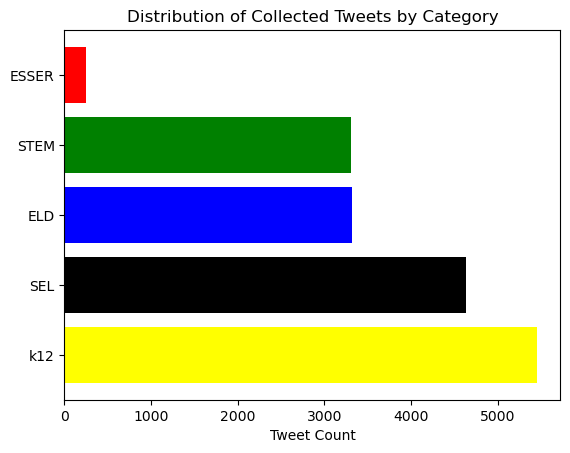

In [25]:
plt.rcdefaults()
fig, ax = plt.subplots()

# Example data
tags = ('ESSER','STEM', 'ELD', 'SEL', 'k12')
true_count_data = (true_count_ESSER, true_count_STEM, true_count_ELD, true_count_SEL, true_count_k12)

y_pos = np.arange(len(tags))
my_colors = ['red', 'green', 'blue', 'black', 'yellow']


ax.barh(y_pos, true_count_data, align='center', color = my_colors)
ax.set_yticks(y_pos)
ax.set_yticklabels(tags)
ax.invert_yaxis()  # labels read top-to-bottom
ax.set_xlabel('Tweet Count')
ax.set_title('Distribution of Collected Tweets by Category')

plt.show()

#### Top Tweet Appearances w/in Dataset

In [26]:
top_text_appearances = df_tweets_en.value_counts('text')[0:8]

#Counts
top_8_texts = [234, 207, 102, 96, 84, 82, 68, 66]

#Convert to string to extract w/ reg ex
top_text_appearances_string = top_text_appearances.to_string()

#Extractor
link_regex = re.compile('((https?):((//)|(\\\\))+([\w\d:#@%/;$()~_?\+-=\\\.&](#!)?)*)', re.DOTALL)

#Extract Links
top_8_links = re.findall(link_regex, top_text_appearances_string)

link_storage = []
for link in top_8_links:
    link_storage.append(link[0])
    
#Create dictionary matching top texts with links
top_8_texts_dict = dict(zip(link_storage,top_8_texts))

In [27]:
top_8_texts_dict

{'https://t.co/gsXqUGRiiu': 234,
 'https://t.co/yfW1tu4PS1': 207,
 'https://t.co/aUBCOMRW3x': 102,
 'https://t.co/1rsrFL2L44': 96,
 'https://t.co/WqYDMc9ICg': 84,
 'https://t.co/IAmy6GuWa5': 82,
 'https://t.co/0WsPgHSwJC': 68,
 'https://t.co/zNtNqq03AH': 66}

#### Further cleaning - Working with Unique Tweet texts

In [28]:
#drop duplicates from text column
df_tweets_en.drop_duplicates(subset='text',inplace=True)

<ipython-input-28-ba53646c00d5>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_tweets_en.drop_duplicates(subset='text',inplace=True)


In [29]:
# View Data
df_tweets_en.to_csv('df_tweets_en.csv', index=True)

In [32]:
# Delete a few recognizable rows that aren't aligned with desired content or are repeats
df_tweets_en = df_tweets_en.drop(df_tweets_en.index[[5,11,20]])

In [34]:
df_tweets_en = df_tweets_en.drop(df_tweets_en.index[21])

In [36]:
df_tweets_en.shape

(7155, 12)

#### Tweets with two categories

In [37]:
#Create combinations of two categories
conditions = [
    (df_tweets_en['SocialEmotionalLearning'] == True) & (df_tweets_en['EnglishLanguageDevelopment'] == True),
    (df_tweets_en['SocialEmotionalLearning'] == True) & (df_tweets_en['STEMeducation'] == True),
    (df_tweets_en['SocialEmotionalLearning'] == True) & (df_tweets_en['ESSER'] == True),
    (df_tweets_en['SocialEmotionalLearning'] == True) & (df_tweets_en['k12'] == True),
    (df_tweets_en['EnglishLanguageDevelopment'] == True) & (df_tweets_en['STEMeducation'] == True),
    (df_tweets_en['EnglishLanguageDevelopment'] == True) & (df_tweets_en['ESSER'] == True),
    (df_tweets_en['EnglishLanguageDevelopment'] == True) & (df_tweets_en['k12'] == True),
    (df_tweets_en['STEMeducation'] == True) & (df_tweets_en['ESSER'] == True),
    (df_tweets_en['STEMeducation'] == True) & (df_tweets_en['k12'] == True),
    (df_tweets_en['ESSER'] == True) & (df_tweets_en['k12'] == True)]
choices = ['SEL & ELD', 'SEL & STEM', 'SEL & ESSER', 'SEL & k12', 'ELD & STEM',
           'ELD & ESSER', 'ELD & k12', 'STEM & ESSER', 'STEM & k12', 'ESSER & k12'
          ]
df_tweets_en['CombinedCategories'] = np.select(conditions, choices, default = 'Single')

<AxesSubplot:title={'center':'Tweets with Two Categories'}, xlabel='Combinations', ylabel='Number of Tweets'>

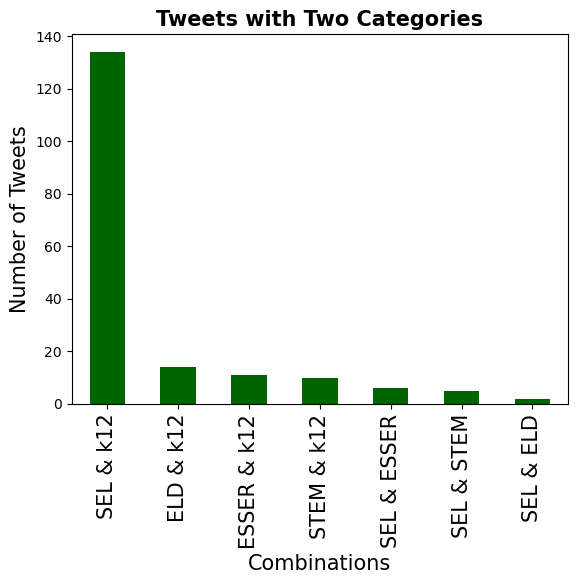

In [38]:
combined_tweets = df_tweets_en['CombinedCategories'].value_counts()

fig, ax = plt.subplots()
ax.tick_params(axis='x', labelsize=15)
ax.tick_params(axis='y', labelsize=10)
ax.set_xlabel('Combinations', fontsize=15)
ax.set_ylabel('Number of Tweets' , fontsize=15)
ax.set_title('Tweets with Two Categories', fontsize=15, fontweight='bold')
combined_tweets[1:8].plot(ax=ax, kind='bar', color='darkgreen')

In [269]:
combined_tweets

Single         6972
SEL & k12       134
ELD & k12        14
ESSER & k12      11
STEM & k12       10
SEL & ESSER       6
SEL & STEM        5
SEL & ELD         2
ELD & STEM        1
Name: CombinedCategories, dtype: int64

#### Retweet Count by Category and Visualization

In [39]:
# Sum retweet counts for each category
retweet_STEM_agg = df_tweets_en.loc[df_tweets_en['STEMeducation'] == True].retweet_count.sum()
retweet_ELD_agg = df_tweets_en.loc[df_tweets_en['EnglishLanguageDevelopment'] == True].retweet_count.sum()
retweet_SEL_agg = df_tweets_en.loc[df_tweets_en['SocialEmotionalLearning'] == True].retweet_count.sum()
retweet_ESSER_agg = df_tweets_en.loc[df_tweets_en['ESSER'] == True].retweet_count.sum()
retweet_k12_agg = df_tweets_en.loc[df_tweets_en['k12'] == True].retweet_count.sum()

In [259]:
# Create a dataframe with retweet count totals
retweet_ct_column = ['Retweet Count','SEL', 'ELD', 'k12', 'STEM', 'ESSER']
retweet_ct = [['',retweet_SEL_agg, retweet_ELD_agg, retweet_k12_agg, retweet_STEM_agg,  retweet_ESSER_agg]]
retweet_cd_df = pd.DataFrame(retweet_ct, columns = retweet_ct_column)
retweet_cd_df

,Retweet Count,SEL,ELD,k12,STEM,ESSER
0,,7504.0,3989.0,2390.0,1912.0,228.0


In [262]:
# Sum up all categories and get respective percentages
df_total = retweet_cd_df['SEL'] + retweet_cd_df['ELD'] + retweet_cd_df['k12'] + retweet_cd_df['STEM'] + retweet_cd_df['ESSER']
df_rel = retweet_cd_df[retweet_cd_df.columns[1:]].div(df_total, 0)*100

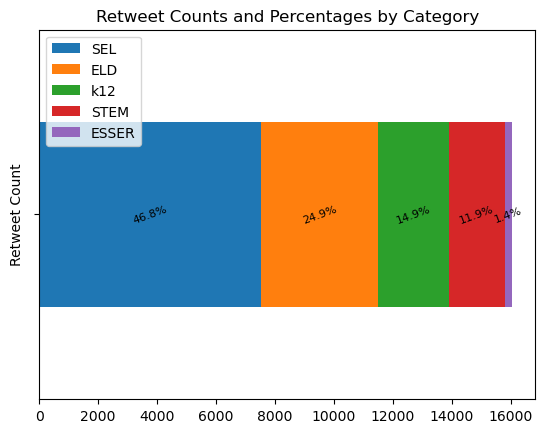

In [266]:
# Plot Retweet Count %s by category against total retweets
retweet_cd_df.plot(
  x = 'Retweet Count', 
  kind = 'barh', 
  stacked = True, 
  title = 'Retweet Counts and Percentages by Category', 
  mark_right = True)

for n in df_rel:
    for i, (cs, ab, pc) in enumerate(zip(retweet_cd_df.iloc[:, 1:].cumsum(1)[n], 
                                         retweet_cd_df[n], df_rel[n])):
        plt.text(cs - ab / 2, i, str(np.round(pc, 1)) + '%', 
                 va = 'center', ha = 'center', rotation = 20, fontsize = 8)

### Sentiment Analysis - NLTK

#### Preparing the data

In [273]:
sent_df = df_tweets_en.copy()

In [276]:
#create a list of stopwords
from nltk.corpus import stopwords
additional  = ['rt','rts','retweet']
stop_words = set().union(stopwords.words('english'),additional)

In [277]:
stop_words

{'a',
 'about',
 'above',
 'after',
 'again',
 'against',
 'ain',
 'all',
 'am',
 'an',
 'and',
 'any',
 'are',
 'aren',
 "aren't",
 'as',
 'at',
 'be',
 'because',
 'been',
 'before',
 'being',
 'below',
 'between',
 'both',
 'but',
 'by',
 'can',
 'couldn',
 "couldn't",
 'd',
 'did',
 'didn',
 "didn't",
 'do',
 'does',
 'doesn',
 "doesn't",
 'doing',
 'don',
 "don't",
 'down',
 'during',
 'each',
 'few',
 'for',
 'from',
 'further',
 'had',
 'hadn',
 "hadn't",
 'has',
 'hasn',
 "hasn't",
 'have',
 'haven',
 "haven't",
 'having',
 'he',
 'her',
 'here',
 'hers',
 'herself',
 'him',
 'himself',
 'his',
 'how',
 'i',
 'if',
 'in',
 'into',
 'is',
 'isn',
 "isn't",
 'it',
 "it's",
 'its',
 'itself',
 'just',
 'll',
 'm',
 'ma',
 'me',
 'mightn',
 "mightn't",
 'more',
 'most',
 'mustn',
 "mustn't",
 'my',
 'myself',
 'needn',
 "needn't",
 'no',
 'nor',
 'not',
 'now',
 'o',
 'of',
 'off',
 'on',
 'once',
 'only',
 'or',
 'other',
 'our',
 'ours',
 'ourselves',
 'out',
 'over',
 'own',
 'r

In [279]:
'''transform tweet text into lowercase, remove twitter handles, remove hyperlinks,
remove non-alphanumeric characters such as punctuation marks, remove whitespace. '''

sent_df['processed_text'] = sent_df['text'].str.lower()\
          .str.replace('(@[a-z0-9]+)\w+',' ')\
          .str.replace('(http\S+)', ' ')\
          .str.replace('([^0-9a-z \t])',' ')\
          .str.replace(' +',' ')\
          .apply(lambda x: [i for i in x.split() if not i in stop_words])

In [280]:
sent_df.head(10)

,user-screen_name,text,user-location,lang,retweet_count,created_at,hashtags,SocialEmotionalLearning,STEMeducation,EnglishLanguageDevelopment,ESSER,k12,CombinedCategories,processed_text
0,GregKiesman,The latest The Digital Teacher! https://t.co/4...,"Winnipeg, Manitoba, Canada",en,0.0,Tue Jul 06 13:09:59 +0000 2021,"[education, k12]",False,False,False,False,True,Single,"[latest, digital, teacher, education, k12]"
2,karlDcollins,Still looking for #freelance #science writers....,Germany since 2012 (prev. UK),en,0.0,Tue Jul 06 13:11:28 +0000 2021,"[freelance, science]",False,True,False,False,False,Single,"[still, looking, freelance, science, writers, ..."
3,maidanulada,Would you like to watch a shortish video on ho...,"Bangkok, Thailand",en,75.0,Tue Jul 06 13:11:30 +0000 2021,None,False,False,True,False,False,Single,"[would, like, watch, shortish, video, use, vag..."
4,Ballewedtech,"Please join me in #celebrating @janetmelling, ...","Bloomington, MN",en,1.0,Tue Jul 06 13:11:31 +0000 2021,"[celebrating, GCEL2, GoogleEDU]",False,False,False,False,True,Single,"[please, join, celebrating, achieving, gcel2, ..."
5,patriclougheed,The latest Blended Learning Daily! https://t.c...,Vancouver Island,en,0.0,Tue Jul 06 13:11:59 +0000 2021,"[tesol, esl]",False,False,True,False,False,Single,"[latest, blended, learning, daily, thanks, tes..."
7,education_24x7,Simple things you can do as a teacher to ensur...,Delhi,en,1.0,Tue Jul 06 13:12:41 +0000 2021,[edchat],False,False,False,False,True,Single,"[simple, things, teacher, ensure, supply, teac..."
8,GPHarvard,"In our webinar ""Teaching Good Work in the Clas...",Harvard University,en,0.0,Tue Jul 06 13:13:03 +0000 2021,None,False,False,False,False,True,Single,"[webinar, teaching, good, work, classroom, inv..."
9,jenallen_edtech,There are a lot of buzzwords floating around i...,None,en,1.0,Tue Jul 06 13:13:14 +0000 2021,None,True,False,False,False,False,Single,"[lot, buzzwords, floating, around, education, ..."
11,DocSmithTeacher,Model and empower continuous improvement with ...,Missouri,en,3.0,Tue Jul 06 13:14:07 +0000 2021,"[GrowthMindset, Education, EdChat, SEL]",True,False,False,False,False,Single,"[model, empower, continuous, improvement, grow..."
12,coopmike48,Big Education Ape: TOP POSTS THIS WEEK Saturda...,California,en,0.0,Tue Jul 06 13:14:26 +0000 2021,"[REDFORED, tbats, openonlywhensafe, edchat, K12]",False,False,False,False,True,Single,"[big, education, ape, top, posts, week, saturd..."


In [282]:
'''Tranform text through stemming '''
from nltk.stem import PorterStemmer
ps = PorterStemmer()
sent_df['stemmed'] = sent_df['processed_text'].apply(lambda x: [ps.stem(i) for i in x if i != ''])

In [300]:
columnsTitles = ['text', 'processed_text', 'stemmed']
frame = sent_df.reindex(columns=columnsTitles)
frame.head(10)

,text,processed_text,stemmed
0,The latest The Digital Teacher! https://t.co/4...,"[latest, digital, teacher, education, k12]","[latest, digit, teacher, educ, k12]"
2,Still looking for #freelance #science writers....,"[still, looking, freelance, science, writers, ...","[still, look, freelanc, scienc, writer, articl..."
3,Would you like to watch a shortish video on ho...,"[would, like, watch, shortish, video, use, vag...","[would, like, watch, shortish, video, use, vag..."
4,"Please join me in #celebrating @janetmelling, ...","[please, join, celebrating, achieving, gcel2, ...","[pleas, join, celebr, achiev, gcel2, today, wo..."
5,The latest Blended Learning Daily! https://t.c...,"[latest, blended, learning, daily, thanks, tes...","[latest, blend, learn, daili, thank, tesol, esl]"
7,Simple things you can do as a teacher to ensur...,"[simple, things, teacher, ensure, supply, teac...","[simpl, thing, teacher, ensur, suppli, teacher..."
8,"In our webinar ""Teaching Good Work in the Clas...","[webinar, teaching, good, work, classroom, inv...","[webinar, teach, good, work, classroom, invit,..."
9,There are a lot of buzzwords floating around i...,"[lot, buzzwords, floating, around, education, ...","[lot, buzzword, float, around, educ, two, may,..."
11,Model and empower continuous improvement with ...,"[model, empower, continuous, improvement, grow...","[model, empow, continu, improv, growthmindset,..."
12,Big Education Ape: TOP POSTS THIS WEEK Saturda...,"[big, education, ape, top, posts, week, saturd...","[big, educ, ape, top, post, week, saturday, ju..."


#### Sentiment Analysis w/ VADER

In [301]:
# import and download VADER
import nltk.sentiment.vader as vd
from nltk import download
download('vader_lexicon')
sia = vd.SentimentIntensityAnalyzer()

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /Users/jordanvargas/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [302]:
# Tokenize process text and produce sentiment scores
from nltk.tokenize import word_tokenize
sent_df['sentiment_score'] = sent_df['processed_text'].apply(lambda x: sum([ sia.polarity_scores(i)['compound'] for i in word_tokenize( ' '.join(x) )]) )

In [312]:
pd.set_option('display.max_colwidth', None)
sent_df[['processed_text', 'sentiment_score']].sort_values('sentiment_score', ascending = False).head(5)

,processed_text,sentiment_score
12343,"[feeling, today, inspired, minds, hope, feeling, happy, capable, grateful, confident, beautiful, please, check, free, teaching, ideas, resources, inspire, us, sel, growthmindset, selfcare]",5.0968
8321,"[studentoftheweek, karla, completed, esl, class, working, health, screener, karla, kind, words, gratitude, want, thank, restore, education, teacher, restore, education, given, great, gift, thank, karla, congratulations, adulted]",4.0936
25379,"[idiom, wish, someone, best, luck, say, hope, someone, success, wish, best, luck, new, city, esl, efl, ell, tesol, tefl, idioms, learnenglish]",4.0075
10489,"[thank, 2, great, trainings, today, loved, learning, dyslexia, dysgraphia, best, practices, little, humans, best, part, social, emotional, connection, thrown, blessed, part, district, supports, learners]",3.9730
3442,"[answer, question, tag, friend, win, free, month, baamboozle, 1, winner, chosen, random, tomorrow, best, luck, gamebasedlearning, gamification, edchat, competition, win, esl, gbl, ela]",3.8579


In [314]:
sent_df[['processed_text', 'sentiment_score']].sort_values('sentiment_score', ascending = True).head(5)

,processed_text,sentiment_score
6752,"[ag, called, hateful, group, another, man, advocated, closing, government, schools, social, emotional, learning, includes, anti, bullying, education, empathy, want, kids, anti, racist, anti, bullies]",-2.4300
14568,"[diagnosed, autism, motor, dysproxia, social, learning, disability, emotional, delay, course, delay, word, got, odd, cuz, give, conduct, disorder, cuz, lie, cheat, steal, manipulate, people]",-2.1561
13395,"[mentalhealth, professionals, doctors, around, globe, warning, year, stress, isolation, grief, fear, students, simply, spring, back, school, k12, education, edchat]",-2.1512
11467,"[cruel, keeping, people, livelihood, assuage, irrational, fear, virus, kills, less, 1, people, get, cruel, keeping, kids, school, hindering, social, emotional, development, learning, fuck, love, ron]",-2.0980
12155,"[outgrowth, social, emotional, learning, orthodox, k, 12, education, premised, idiotic, psychological, cult, belief, trauma, single, cause, human, dysfunction, making, prevention, mitigation, trauma, single, cure, human, dysfunction]",-2.0903


In [318]:
#Average Sentiment Score for dataset
sent_df['sentiment_score'].mean()

0.5785864290705773

In [344]:
'''Grouping and Averaging by Category'''
sel_sent = sent_df.groupby('SocialEmotionalLearning')['sentiment_score'].mean()
eld_sent = sent_df.groupby('EnglishLanguageDevelopment')['sentiment_score'].mean()
k12_sent = sent_df.groupby('k12')['sentiment_score'].mean()
stem_sent = sent_df.groupby('STEMeducation')['sentiment_score'].mean()
esser_sent = sent_df.groupby('ESSER')['sentiment_score'].mean()
sent_scores = [sel_sent[1], stem_sent[1], k12_sent[1], esser_sent[1], eld_sent[1]]
sent_names = ['SocialEmotionalLearning', 'STEMeducation', 'k12', 'ESSER', 'ELD']
sent_dic = dict(zip(sent_names, sent_scores))

In [350]:
for k,v in sent_dic.items():
    print(f"Average sentiment score for {k}:{v:0.02f}")

Average sentiment score for SocialEmotionalLearning:0.74
Average sentiment score for STEMeducation:0.61
Average sentiment score for k12:0.60
Average sentiment score for ESSER:0.57
Average sentiment score for ELD:0.32


In [355]:
#ESSER Top 5 Sentiment Score Tweets
esser_sent = sent_df.loc[sent_df['ESSER']]
esser_sent[['processed_text', 'sentiment_score']].sort_values('sentiment_score', ascending = False).head(5)

,processed_text,sentiment_score
797,"[texas, education, agency, elementary, secondary, school, emergency, relief, iii, esser, iii, fund, grant, positioning, desoto, isd, compete, best, brightest, teachers, across, metroplex, retain, district, amazing, returning, educators]",2.2913
26357,"[dessert, island, ben, zhu, definitely, added, sel, list, words, amp, simplicity, picture, book, strong, kidlit, message, compassion, perspective, kindness, hoping, return, school, make, priorities, year, backtoschool2021]",2.2516
25852,"[saisd, applying, crrsa, esser, ii, arp, esser, iii, funding, respond, covid, help, safely, reopen, sustain, safe, operation, schools, safety, students, click, link, see, safety, measures, plan, drafted, school, year]",2.1792
14859,"[esser, funding, opportunity, transform, practice, schools, identify, pathways, progress, work, best, communities, join, aug, 4th, 4, pm, et, compelling, insights, jtbd]",2.0022
4737,"[today, great, day, register, 7, 22, webinar, using, federal, aid, equitable, education, comeback, agenda, feel, free, join, sessions, interest, registration, edequity, schoolfunding, esser]",1.8903


In [369]:
esser_loc_counts = esser_sent['user-location'].value_counts()

In [372]:
pd.set_option('display.max_rows', 200)
print(esser_loc_counts)

Washington, DC                                                 9
Austin, TX                                                     4
Chicago                                                        3
Milwaukee                                                      3
The heart of the Commonwealth                                  2
Lincoln, NE                                                    2
Arlington, VA                                                  2
Bochum, Germany                                                2
Munster, IN                                                    1
San Carlos, CA                                                 1
NH/MA/Nationwide                                               1
Northern California                                            1
IndigAmericas,UK,Asia,Scan,Oz                                  1
Prince Frederick, Maryland                                     1
Ann Arbor, MI                                                  1
Austin, Texas            

### Named Entity Recognition - spaCy

In [40]:
'''Install spacy - must run from terminal:
    sudo python3 -m spacy download en'''
#pip install spacy
import spacy
nlp = spacy.load('en_core_web_sm')

In [41]:
# Apply the spaCy language model to the entire collection of tweet texts
docs = list(nlp.pipe(df_tweets_en.text))

In [43]:
from spacy import displacy

#Dependency Visualizer w/ spaCy
displacy.render(docs[8], style="dep")

In [52]:
#Noun Chunks
doc_nouns = list(docs[8].noun_chunks)
print(doc_nouns)

[Model, empower continuous improvement, a #GrowthMindset, 🐢, #Education, #EdChat]


In [53]:
# Extract all the properties of each word that we want to include in the table
def extract_tokens_plus_meta(doc:spacy.tokens.doc.Doc):
    """Extract tokens and metadata from individual spaCy doc."""
    return [
        (i.text, i.i, i.lemma_, i.ent_type_, i.tag_, 
         i.dep_, i.pos_, i.is_stop, i.is_alpha, 
         i.is_digit, i.is_punct) for i in doc
    ]

In [54]:
# Define a function to apply the function above to all documents and store the outputs in a Pandas dataframe.

def tidy_tokens(docs):
    """Extract tokens and metadata from list of spaCy docs."""
    
    cols = [
        "doc_id", "token", "token_order", "lemma", 
        "ent_type", "tag", "dep", "pos", "is_stop", 
        "is_alpha", "is_digit", "is_punct"
    ]
    
    meta_df = []
    for ix, doc in enumerate(docs):
        meta = extract_tokens_plus_meta(doc)
        meta = pd.DataFrame(meta)
        meta.columns = cols[1:]
        meta = meta.assign(doc_id = ix).loc[:, cols]
        meta_df.append(meta)
        
    return pd.concat(meta_df)

In [107]:
tidy_docs = tidy_tokens(docs)

In [272]:
tidy_docs.head(20)

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
0,0,The,0,the,NaN,DT,det,DET,True,True,False,False
1,0,latest,1,late,NaN,JJS,amod,ADJ,False,True,False,False
2,0,The,2,the,NaN,DT,det,DET,True,True,False,False
3,0,Digital,3,Digital,ORG,NNP,compound,PROPN,False,True,False,False
4,0,Teacher,4,Teacher,NaN,NNP,ROOT,PROPN,False,True,False,False
5,0,!,5,!,NaN,.,punct,PUNCT,False,False,False,True
6,0,https://t.co/4MbQPooNy0,6,https://t.co/4mbqpoony0,NaN,NN,ROOT,NOUN,False,False,False,False
7,0,#,7,#,NaN,$,det,SYM,False,False,False,True
8,0,education,8,education,NaN,NN,dep,NOUN,False,True,False,False
9,0,#,9,#,NaN,$,det,SYM,False,False,False,True


In [390]:
tidy_docs['doc_id'].max()

7154

In [150]:
# Remove rows with unwanted lemmas \n\n and \n and whitespace
nan_value = float("NaN")
tidy_docs.replace("", nan_value, inplace=True)
tidy_docs.dropna(subset = ["token"], inplace=True

tidy_docs = tidy_docs[tidy_docs.lemma != '\n\n']
tidy_docs = tidy_docs[tidy_docs.lemma != '\n']
tidy_docs = tidy_docs[tidy_docs.lemma != 'amp']

#### Analyzing structured natural language data

In [386]:
len(tidy_docs)

255350

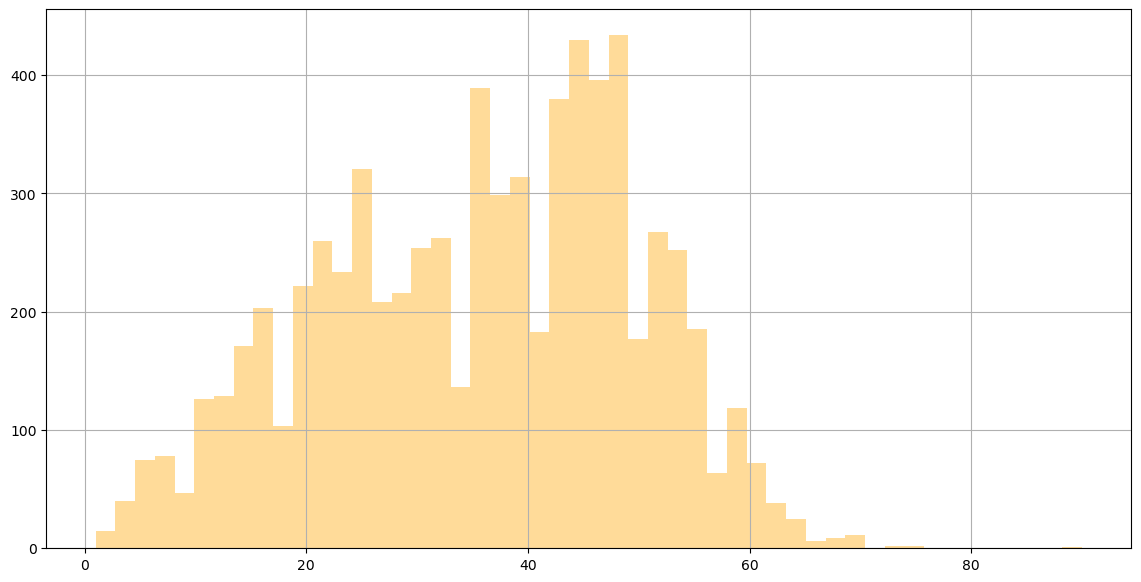

In [388]:
#distribution of tokens in documents
tidy_docs.groupby("doc_id").size().hist(figsize=(14, 7), color="orange", alpha=.4, bins=50);

In [375]:
tidy_docs.query("is_stop == False & is_punct == False").token.value_counts()[1:25]

SEL              1405
learning         1146
ESL               949
k12               936
students          933
K12               898
education         788
STEMeducation     764
STEM              733
English           632
emotional         601
social            571
school            536
edtech            492
edchat            475
Learning          469
esl               455
Social            438
Emotional         382
day               381
teachers          352
schools           342
️                 326
learn             325
Name: token, dtype: int64

In [374]:
tidy_docs.query("is_stop == False & is_punct == False").lemma.value_counts()[1:25]

SEL              1398
student          1187
learn            1073
ESL               948
k12               937
school            926
education         907
K12               897
teacher           771
learning          693
STEM              643
new               635
social            623
STEMeducation     621
emotional         614
edchat            556
edtech            504
English           468
help              457
esl               456
tesol             452
day               438
support           433
thank             428
Name: lemma, dtype: int64

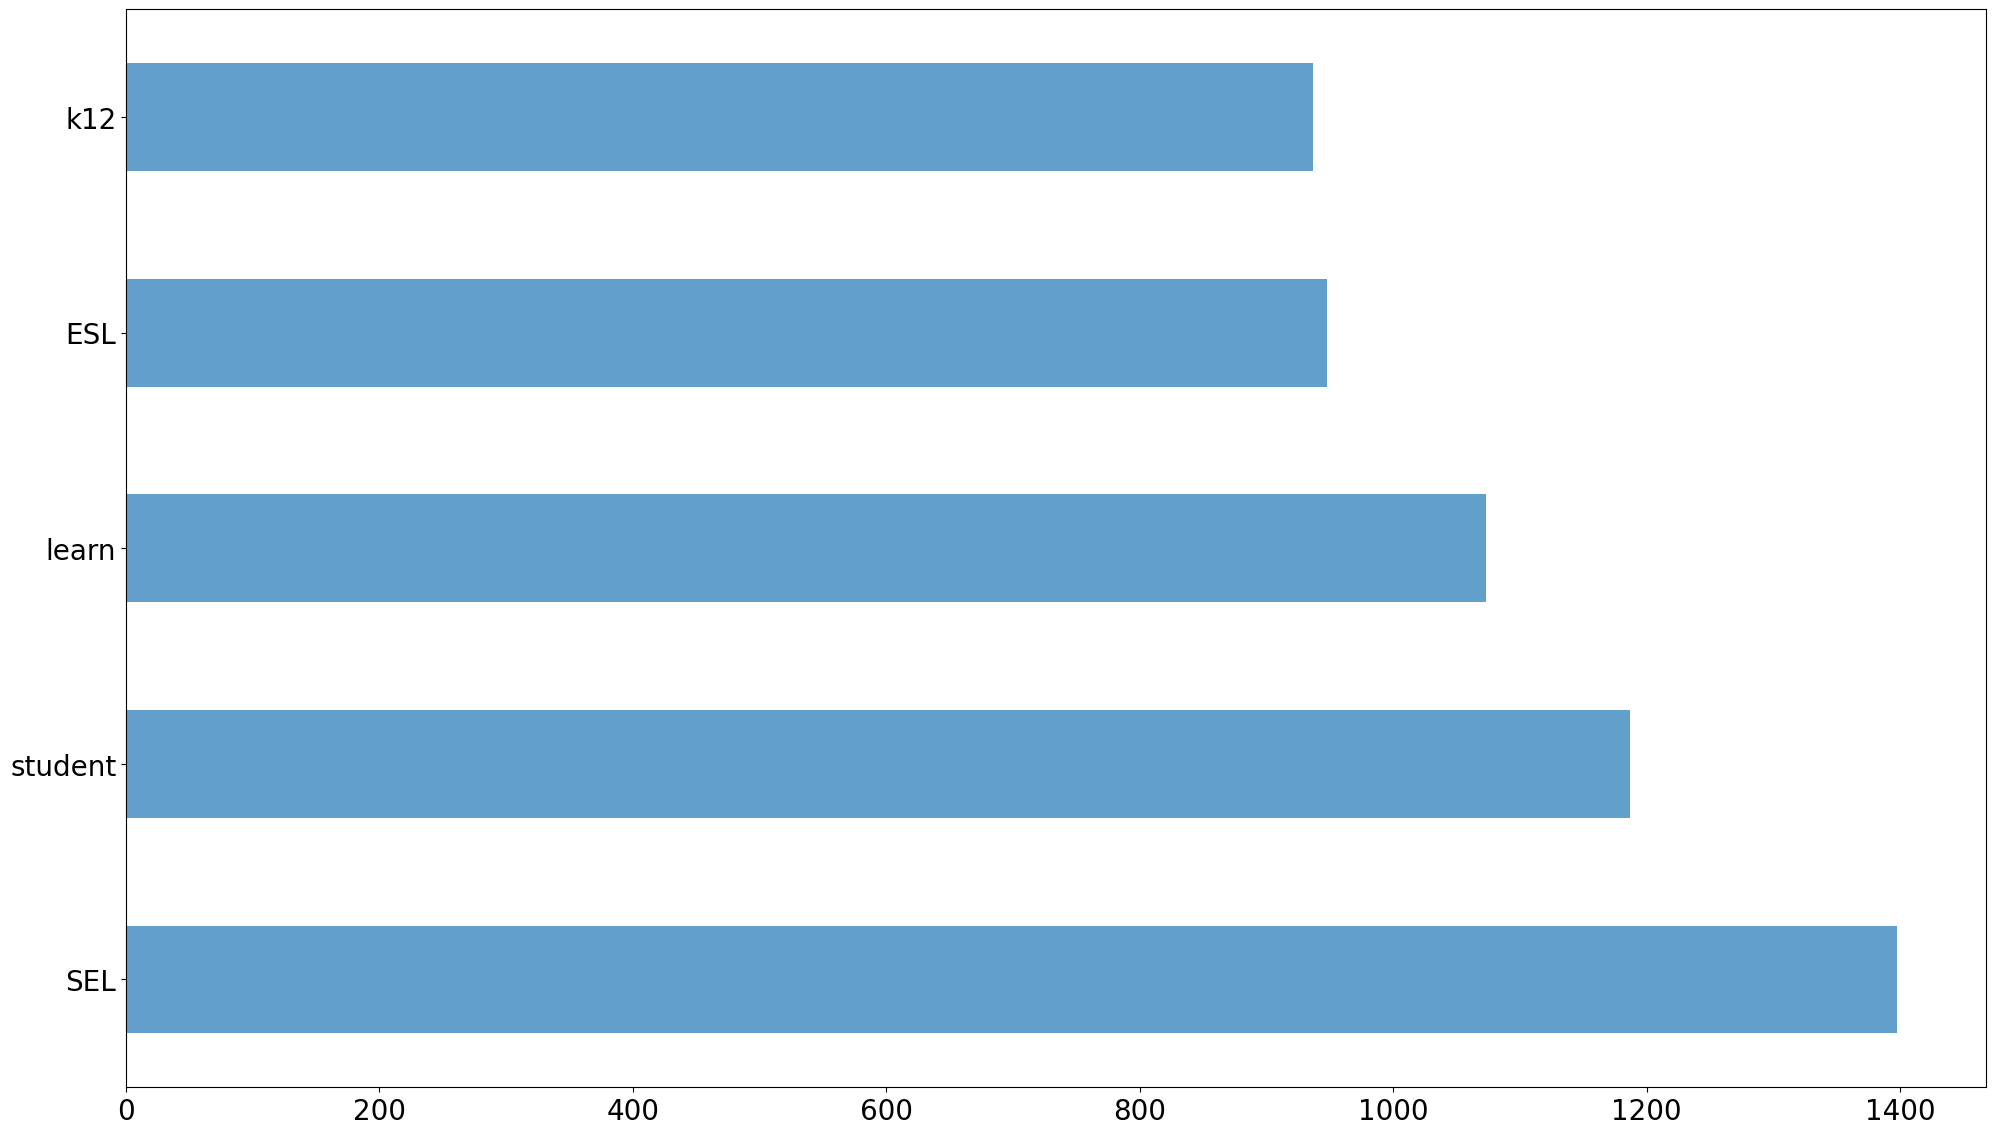

In [383]:
tidy_docs.query("lemma != ' ' & is_stop == False & is_punct == False").lemma.value_counts().head(5).plot(kind="barh", figsize=(24, 14), alpha=.7)
plt.yticks(fontsize=20)
plt.xticks(fontsize=20);

In [378]:
# entity counts
tidy_docs.query("ent_type != ''& is_stop == False & is_punct == False").ent_type.value_counts()

ORG            9771
MONEY          9417
PERSON         3996
DATE           2895
GPE            1643
CARDINAL        923
NORP            869
WORK_OF_ART     788
PRODUCT         482
TIME            353
FAC             222
LANGUAGE        191
EVENT           182
LOC             164
LAW              87
ORDINAL          77
PERCENT          73
QUANTITY         27
Name: ent_type, dtype: int64

In [405]:
# entities aren't very accurate. recommend model tuning
tidy_docs.query("ent_type == 'MONEY' and is_punct == False")

,doc_id,token,token_order,lemma,ent_type,tag,dep,pos,is_stop,is_alpha,is_digit,is_punct
4,1,freelance,4,freelance,MONEY,NN,nmod,NOUN,False,True,False,False
20,1,STEMeducation,20,STEMeducation,MONEY,NNP,compound,PROPN,False,True,False,False
37,2,English,37,English,MONEY,NNP,amod,PROPN,False,True,False,False
43,2,grammar,43,grammar,MONEY,NN,ROOT,NOUN,False,True,False,False
57,2,elt,57,elt,MONEY,NN,dep,NOUN,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...
18,7149,SEL,18,SEL,MONEY,NNP,compound,PROPN,False,True,False,False
43,7153,ELT,43,ELT,MONEY,NNP,compound,PROPN,False,True,False,False
58,7154,ELT,58,ELT,MONEY,NNP,nmod,PROPN,False,True,False,False
60,7154,CPD,60,CPD,MONEY,NNP,compound,PROPN,False,True,False,False
